# Imports

In [1]:
!cp -r /kaggle/input/clinical/data /kaggle/working/data

In [2]:
from datasets import load_dataset, load_from_disk
import seaborn as sns
import os
from huggingface_hub import notebook_login
from rich.pretty import pprint
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import re, ast, numpy as np, spacy
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.compute as pc
from datasets import Dataset

print("Modlues imported sucessfully")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Modlues imported sucessfully


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Set your HF token & username as environment variables
os.environ["HF_TOKEN"] = user_secrets.get_secret("peeter-read-token")
# Replace with your username)
os.environ["HF_USERNAME"] = "PeeterTarvas"

# Analysis of the dataset
## Dataset features

*This data is embedded form the dataset's site: https://huggingface.co/datasets/louisbrulenaudet/clinical-trials*

### Core Study Information
- **nct_id:** Unique study identifier (NCT########)  
- **brief_title:** Concise study title  
- **official_title:** Complete formal study title  
- **study_type:** Study design type (Interventional, Observational, etc.)  
- **phases:** Clinical trial phases (Phase I, II, III, IV)  
- **overall_status:** Current study status  

### Study Design & Population
- **enrollment_count:** Target or actual enrollment number  
- **minimum_age / maximum_age:** Age eligibility bounds  
- **sex:** Gender eligibility (All, Male, Female)  
- **healthy_volunteers:** Whether healthy volunteers are accepted  
- **eligibility_criteria:** Detailed inclusion/exclusion criteria  
- **study_population:** Target population description  

### Clinical Context
- **conditions:** Medical conditions studied  
- **keywords:** Study-related keywords  
- **brief_summary:** Study purpose and rationale  
- **detailed_description:** Comprehensive study description  
- **primary_outcomes / secondary_outcomes:** Measured endpoints  

### Organizational Information
- **lead_sponsor:** Primary study sponsor  
- **collaborators:** Additional supporting organizations  
- **locations:** Study sites with geographic coordinates  
- **overall_officials:** Principal investigators and study officials  

### Temporal Data
- **study_first_submit_date:** Initial submission to ClinicalTrials.gov  
- **start_date:** Study start date  
- **primary_completion_date:** Primary endpoint completion date  
- **completion_date:** Overall study completion date  
- **last_update_submit_date:** Most recent data update date  

### Enhanced Features
- **brief_summary_embedding:** 768-dimensional semantic embedding of study summary  
- **eligibility_criteria_embedding:** 768-dimensional embedding of eligibility text  

## Load dataset

If dataset is present on your device, then load it from disk, otherwise, load it from internet and save it on disk

In [4]:
path_to_ds = "clinical-dataset" # your path to the dataset

print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "clinical-dataset"


In [5]:

if os.path.exists(path_to_ds): # load from disk if present, otherwise download it from HF
    dataset = load_from_disk(path_to_ds)
else:
    dataset = load_dataset("louisbrulenaudet/clinical-trials", split="train")
    dataset.save_to_disk(path_to_ds)

train_data = dataset

print("Dataset loaded successfully")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/541897 [00:00<?, ? examples/s]

Saving the dataset (0/8 shards):   0%|          | 0/541897 [00:00<?, ? examples/s]

Dataset loaded successfully


### Print dataset details

In [6]:
original_ds_size = len(train_data)
print(f"Dataset size: {original_ds_size}")
print("Features:")
pprint(train_data.features)

Dataset size: 541897
Features:


{
│   'nct_id': Value('string'),
│   'updated_at': Value('timestamp[us]'),
│   'brief_title': Value('string'),
│   'official_title': Value('string'),
│   'acronym': Value('string'),
│   'study_type': Value('string'),
│   'overall_status': Value('string'),
│   'study_first_submit_date': Value('timestamp[ms]'),
│   'start_date': Value('timestamp[ms]'),
│   'primary_completion_date': Value('timestamp[ms]'),
│   'completion_date': Value('timestamp[ms]'),
│   'phases': List(Value('string')),
│   'enrollment_count': Value('float64'),
│   'minimum_age': Value('float64'),
│   'maximum_age': Value('float64'),
│   'sex': Value('string'),
│   'healthy_volunteers': Value('bool'),
│   'brief_summary': Value('string'),
│   'detailed_description': Value('string'),
│   'eligibility_criteria': Value('string'),
│   'lead_sponsor_name': Value('string'),
│   'lead_sponsor_class': Value('string'),
│   'org_study_id_info': {'id': Value('string'), 'link': Value('string'), 'type': Value('string')},
│   'why_stopped': Value('string'),
│   'expanded_access_info': {
│   │   'hasExpandedAccess': Value('bool'),
│   │   'nctId': Value('string'),
│   │   'statusForNctId': Value('string')
│   },
│   'last_update_submit_qc_date': Value('timestamp[ms]'),
│   'last_update_post_date_struct': {'date': Value('string'), 'type': Value('string')},
│   'study_first_post_date_struct': {'date': Value('string'), 'type': Value('string')},
│   'std_ages': List(Value('string')),
│   'study_population': Value('string'),
│   'sampling_method': Value('string'),
│   'oversight_has_dmc': Value('bool'),
│   'design_info': {
│   │   'allocation': Value('string'),
│   │   'interventionModel': Value('string'),
│   │   'interventionModelDescription': Value('string'),
│   │   'maskingInfo': {
│   │   │   'masking': Value('string'),
│   │   │   'maskingDescription': Value('string'),
│   │   │   'whoMasked': List(Value('string'))
│   │   },
│   │   'observationalModel': Value('string'),
│   │   'primaryPurpose': Value('string'),
│   │   'timePerspective': Value('string')
│   },
│   'conditions': List(Value('string')),
│   'keywords': Value('string'),
│   'interventions': Value('null'),
│   'locations': List({'city': Value('string'), 'country': Value('string'), 'facility': Value('string'), 'geoPoint': {'lat': Value('float64'), 'lon': Value('float64')}, 'state': Value('string')}),
│   'collaborators': List({'class': Value('string'), 'name': Value('string')}),
│   'arm_groups': Value('null'),
│   'outcomes': {
│   │   'other': List({'description': Value('null'), 'measure': Value('string'), 'timeFrame': Value('string')}),
│   │   'primary': List({'description': Value('null'), 'measure': Value('string'), 'timeFrame': Value('string')}),
│   │   'secondary': List({'description': Value('null'), 'measure': Value('string'), 'timeFrame': Value('string')})
│   },
│   'overall_officials': List({'affiliation': Value('string'), 'name': Value('string'), 'role': Value('string')}),
│   'study_references': Value('string'),
│   'misc_info_module': Value('string'),
│   'condition_browse_module': {
│   │   'ancestors': List({'id': Value('string'), 'term': Value('string')}),
│   │   'browseBranches': List({'abbrev': Value('string'), 'name': Value('string')}),
│   │   'browseLeaves': List({'asFound': Value('string'), 'id': Value('string'), 'name': Value('string'), 'relevance': Value('string')}),
│   │   'meshes': List({'id': Value('string'), 'term': Value('string')})
│   },
│   'intervention_browse_module': {
│   │   'ancestors': List({'id': Value('string'), 'term': Value('string')}),
│   │   'browseBranches': List({'abbrev': Value('string'), 'name': Value('string')}),
│   │   'browseLeaves': List({'asFound': Value('string'), 'id': Value('string'), 'name': Value('string'), 'relevance': Value('string')}),
│   │   'meshes': List({'id': Value('string'), 'term': Value('string')})
│   },
│   'mesh_terms': {
│   │   'conditions': List({'id': Value('string'), 'term': Value('string')}),
│   │   'interventions': List({

### Example of data

In [7]:
sample = train_data.select(range(10)).to_pandas()

sample

# Projection only to relevant fileds
# sample["nct_id"] # Ids
# sample[["brief_title", "brief_summary", "detailed_description", "eligibility_criteria", "keywords"]] # Free text 
# sample[["mesh_terms", "condition_browse_module", "intervention_browse_module"]] # Structured text
# sample[["conditions", "interventions"]] # Validation data

,nct_id,updated_at,brief_title,official_title,acronym,study_type,overall_status,study_first_submit_date,start_date,primary_completion_date,...,locations,collaborators,arm_groups,outcomes,overall_officials,study_references,misc_info_module,condition_browse_module,intervention_browse_module,mesh_terms
0,NCT01273766,NaT,Deferasirox in Treating Iron Overload Caused B...,Impact of Intervention With Deferasirox on the...,None,INTERVENTIONAL,COMPLETED,2011-01-07,NaT,NaT,...,"[{'city': 'Winston-Salem', 'country': 'United ...","[{'class': 'NIH', 'name': 'National Cancer Ins...",None,"{'other': None, 'primary': [{'description': No...",[{'affiliation': 'Wake Forest University Healt...,None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': [{'id': 'D004194', 'term': 'Dise...","{'ancestors': [{'id': 'D007502', 'term': 'Iron...","{'conditions': [{'id': 'D002051', 'term': 'Bur..."
1,NCT00787566,NaT,"Phase 2 Study of Efficacy, Tolerability, and S...","A Randomized, Single Administration, Double-bl...",None,INTERVENTIONAL,COMPLETED,2008-11-05,NaT,NaT,...,[{'city': 'The study is managed by Kendle Inte...,None,None,"{'other': None, 'primary': [{'description': No...",None,None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': [{'id': 'D012817', 'term': 'Sign...","{'ancestors': [{'id': 'D000932', 'term': 'Anti...","{'conditions': [{'id': 'D009325', 'term': 'Nau..."
2,NCT00497666,NaT,Association Between Rosiglitazone Use and Clin...,Retrospective Study Evaluating the Association...,None,OBSERVATIONAL,UNKNOWN,2007-07-06,NaT,NaT,...,"[{'city': 'Zerifin,', 'country': 'Israel', 'fa...",None,None,None,"[{'affiliation': 'Nephrology Division, Assaf H...",None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': [{'id': 'D014570', 'term': 'Urol...","{'ancestors': None, 'browseBranches': [{'abbre...","{'conditions': [{'id': 'D007674', 'term': 'Kid..."
3,NCT01978366,NaT,Open Label Extension Study of HT-100 in Patien...,An Open Label Extension Study of HT-100 in Pat...,None,INTERVENTIONAL,TERMINATED,2013-10-31,NaT,2016-04-30,...,"[{'city': 'Sacramento', 'country': 'United Sta...",None,None,"{'other': None, 'primary': [{'description': No...","[{'affiliation': 'AkashiTherapeutics', 'name':...",None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': [{'id': 'D020966', 'term': 'Musc...","{'ancestors': [{'id': 'D000970', 'term': 'Anti...","{'conditions': [{'id': 'D009136', 'term': 'Mus..."
4,NCT01971866,NaT,Camera Based System to Monitor Patient Movemen...,Improving Safety and Accuracy of Proton Therap...,DS02,OBSERVATIONAL,TERMINATED,2013-10-17,NaT,NaT,...,"[{'city': 'Jacksonville', 'country': 'United S...",None,None,"{'other': None, 'primary': [{'description': No...",[{'affiliation': 'University of Florida Proton...,None,"{""versionHolder"": ""2025-06-18""}",None,None,None
5,NCT04912466,NaT,IBI322 Monotherapy or Combination Therapy in S...,"A Phase 1a/1b Study Evaluating the Safety, Tol...",None,INTERVENTIONAL,COMPLETED,2021-05-28,NaT,2022-12-03,...,"[{'city': 'Jinan', 'country': 'China', 'facili...",None,None,"{'other': None, 'primary': [{'description': No...","[{'affiliation': 'No.440, Jiyan Road, Jinang C...",None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': None, 'browseBranches': None, 'b...","{'ancestors': None, 'browseBranches': [{'abbre...","{'conditions': [{'id': 'D009369', 'term': 'Neo..."
6,NCT03409666,NaT,Randomized Controlled RSA Study Comparing the ...,Randomized Controlled Study Comparing the Tape...,None,INTERVENTIONAL,COMPLETED,2018-01-08,NaT,2020-11-06,...,"[{'city': 'Roosendaal', 'country': 'Netherland...",None,None,"{'other': None, 'primary': [{'description': No...","[{'affiliation': 'Zimmer Biomet', 'name': 'Pao...",None,"{""versionHolder"": ""2025-06-18""}","{'ancestors': [{'id': 'D001168', 'term': 'Arth...",None,"{'conditions': [{'id': 'D010003', 'term': 'Ost..."
7,NCT00622466,NaT,Sorafenib and Paclitaxel in Treating Patients ...,Phase II Trial of Sorafenib and Paclitaxel for...,None,INTERVENTIONAL,TERMINATED,2008-02-22,NaT

### Project and dataset

The Group has decided to move forward with Peter's 1st proposed idea, which is *Forecasting emerging research areas*, in order to be able carry out the task successfully, we need to check if the data is enough to continue with this project. So we check for missingness of features.

In [8]:
date_columns = {
    "study_first_submit_date",
    "start_date",
    "primary_completion_date",
    "completion_date",
}

summary = []
table = train_data.data  # get underlying pyarrow.Table
total = train_data.num_rows

def to_timestamp_ns(chunked): # using some ways to cast it to unified measure
    # If already timestamp, return
    if pa.types.is_timestamp(chunked.type) and chunked.type.unit == "ns":
        return chunked
    
    # If timestamp but different unit -> casting to correct
    if pa.types.is_timestamp(chunked.type):
        return pc.cast(chunked, pa.timestamp("ns"))
    
    # If date32/date64 -> cast up to timestamp
    if pa.types.is_date32(chunked.type) or pa.types.is_date64(chunked.type):
        return pc.cast(pc.cast(chunked, pa.timestamp("ns")), pa.timestamp("ns"))
    
    # If string/large_string -> parse
    if pa.types.is_string(chunked.type) or pa.types.is_large_string(chunked.type):
        ts = pc.strptime(chunked, format="%Y-%m-%d", unit="ns", error_is_null=True) # Adjust format(s) if your data varies, this assumes YYYY-MM-DD
        return ts
    
    # Otherwise: not a date-like type
    return None

for name in train_data.column_names:
    col = table[name]  # access pyarrow.ChunkedArray

    miss = col.null_count
    non_miss = total - miss
    missing_pct = (miss / total * 100) if total else None

    min_date = None
    max_date = None

    if name in date_columns:
        ts = to_timestamp_ns(col)
        if ts is not None:
            valid = pc.drop_null(ts)
            if valid.length() > 0:
                min_date = pc.min(valid).as_py() # Arrow min/max runs in C++ -> very fast
                max_date = pc.max(valid).as_py()

    summary.append({
        "column": name,
        "total_rows": total,
        "missing": miss,
        "missing_%": None if missing_pct is None else round(missing_pct, 2),
        "non_missing": non_miss,
        "min_date": min_date,
        "max_date": max_date,
    })

missing_summary = Dataset.from_list(summary).sort("missing_%", reverse=True)

missing_summary = missing_summary.to_pandas()

print("\nTop 20 columns by missing percentage:")
missing_summary.head(20)


Top 20 columns by missing percentage:


,column,total_rows,missing,missing_%,non_missing,min_date,max_date
0,updated_at,541897,541897,100.00,0,NaT,NaT
1,start_date,541897,541897,100.00,0,NaT,NaT
2,interventions,541897,541897,100.00,0,NaT,NaT
3,arm_groups,541897,541897,100.00,0,NaT,NaT
4,study_population,541897,420133,77.53,121764,NaT,NaT
5,sampling_method,541897,420118,77.53,121779,NaT,NaT
6,collaborators,541897,367593,67.83,174304,NaT,NaT
7,study_references,541897,363526,67.08,178371,NaT,NaT
8,intervention_browse_module,541897,266172,49.12,275725,NaT,NaT
9,maximum_age,541897,254447,46.95,287450,NaT,NaT


#### Plot the results

/tmp/ipykernel_24/846007154.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_summary, x="missing_%", y="column", palette="viridis")


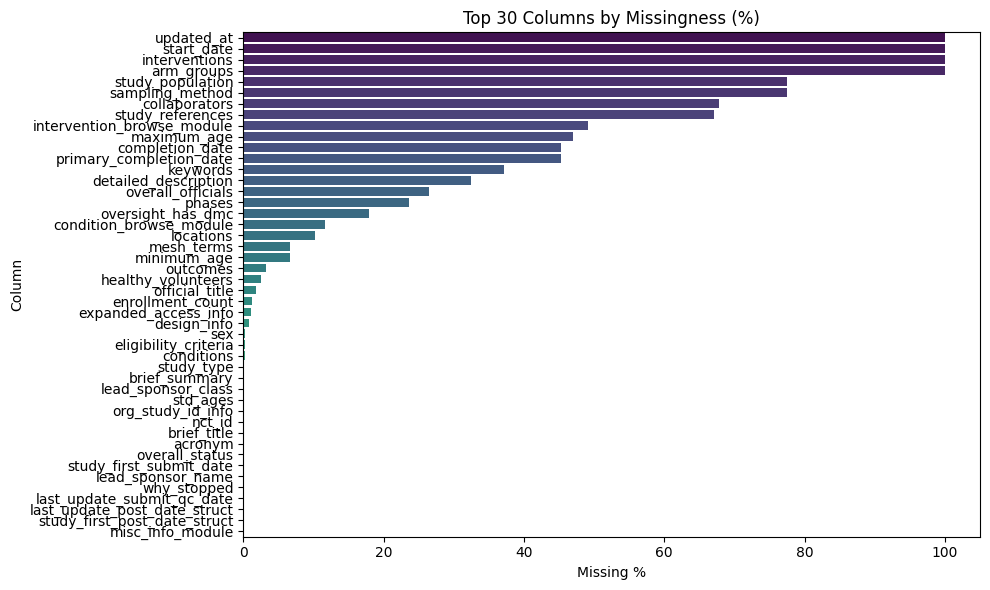

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(data=missing_summary, x="missing_%", y="column", palette="viridis")
plt.title("Top 30 Columns by Missingness (%)")
plt.xlabel("Missing %")
plt.ylabel("Column")
plt.tight_layout()
plt.show()

#### Conclusion

This clearly shows that this project (1st idea) is not a good project on this dataset as the temporal data is highly missing form the dataset. What data is necesseary for the other idea proposed by the team member is however good according to what we can see on this plot. So the team moves forward with the second idea which is the *Anchored Topic Modeling for Interpretable Clinical Trial Landscapes* also made by him.

## Features used for training

As the team decided on the dataset and project, now we filter the features present in the dataset only to the relevant ones for exploration. These are the following.

According to desctiption of the project we will use the following features from the dataset to carry out the task, the fetaures can be groupped into 4 parts, which are the following:

#### Identification:

- `nct_id`

#### Free text:
 - `brief_title`
 - `brief_summary`
 - `detailed_description`
 - `eligibility_criteria`
 - `keywords`

#### Structured text data:
 - `mesh_terms`
 - `condition_browse_module`
 - `intervention_browse_module`

#### Validation data for extracted topics:
 - `conditions`
 - `interventions`

 These features contain useful information related to medical text and context. The **"Free text"** and **"Structured text"** groups will give the backbone of the project's training data, and we can validate the topics using the features in the **"Validation data ..."** group.

In [10]:
ID_COL = [
    "nct_id"
]

FREE_TEXT_COLS = [
    "brief_title",
    "brief_summary",
    "detailed_description",
    "eligibility_criteria",
    "keywords",
]

STRUCTURED_TEXT_COLS = [
    "mesh_terms",
    "condition_browse_module",
    "intervention_browse_module",
]

VALIDATION_COLS = ["conditions", "interventions"]

RELEVANT_COLS = ID_COL + FREE_TEXT_COLS + STRUCTURED_TEXT_COLS + VALIDATION_COLS

print("Relevant columns:")
pprint(RELEVANT_COLS)

Relevant columns:


[
│   'nct_id',
│   'brief_title',
│   'brief_summary',
│   'detailed_description',
│   'eligibility_criteria',
│   'keywords',
│   'mesh_terms',
│   'condition_browse_module',
│   'intervention_browse_module',
│   'conditions',
│   'interventions'
]

#### Research count

Let's see how many unique researches is the team dealing with

In [11]:

def get_unique_ids(dataset):
    unique_ids = dataset.unique("nct_id") # ran in c++ -> fast
    unique_size = len(unique_ids)
    print("unique ids: ", unique_size)
    return unique_size
    
unique_size = get_unique_ids(train_data)

if(original_ds_size == unique_size):
    print("No duplicates in medical researches")
else:
    print("There is duplicate in medical researches")

unique ids:  541897
No duplicates in medical researches


*Based on this evidence we do not need to remove duplicate researches, as they all have uniqie ids.*

#### Filtering data

Now we have seen the missingness ratio and decided which columns we want to use, we can also filter the data in order to use only the rows that meet specific criteria:

*The a row must have either `brief_summary` or `detailed_description` as not None and must have `mesh_terms` and `condition_browse_module`*

Based on this criteria, the dataset is filtered. Although the team upholds that this criteria can change later.

In [12]:
def filter_row(row): # each row is a condition described above
    has_text = (row["brief_summary"] is not None and row["brief_summary"].strip() != "") or (row["detailed_description"] is not None and row["detailed_description"].strip() != "")
    has_mesh_terms = row["mesh_terms"] is not None and len(row["mesh_terms"]) > 0
    has_condition_browse = row["condition_browse_module"] is not None and len(row["condition_browse_module"]) > 0
    
    return has_text and has_mesh_terms and has_condition_browse # conditions connected by conjunction

filtered_ds = train_data.filter(filter_row, num_proc=4)

Filter (num_proc=4):   0%|          | 0/541897 [00:00<?, ? examples/s]

### Projection of datatset

After filtering the rows, the team also need to filter the unncessary columns to save RAM for further operations when loading dataset.

In [13]:
projected_filtered_ds = filtered_ds.select_columns(RELEVANT_COLS) # filter for columns

#### Example of filtered dataset

In [14]:
filtered_pd = projected_filtered_ds.select(range(10)).to_pandas()

filtered_pd.head(10)

,nct_id,brief_title,brief_summary,detailed_description,eligibility_criteria,keywords,mesh_terms,condition_browse_module,intervention_browse_module,conditions,interventions
0,NCT01273766,Deferasirox in Treating Iron Overload Caused B...,RATIONALE: Deferasirox may remove excess iron ...,PRIMARY OBJECTIVES: I. To determine the effect...,Inclusion Criteria:\n\n* Patients must have a ...,None,"{'conditions': [{'id': 'D002051', 'term': 'Bur...","{'ancestors': [{'id': 'D004194', 'term': 'Dise...","{'ancestors': [{'id': 'D007502', 'term': 'Iron...","[Acute Undifferentiated Leukemia, Adult Acute ...",None
1,NCT00787566,"Phase 2 Study of Efficacy, Tolerability, and S...","Brief Summary: A randomized, single administra...",None,Inclusion Criteria:\n\n* Patients with histolo...,"[""Highly emetogenic chemotherapy induced nause...","{'conditions': [{'id': 'D009325', 'term': 'Nau...","{'ancestors': [{'id': 'D012817', 'term': 'Sign...","{'ancestors': [{'id': 'D000932', 'term': 'Anti...",[Chemotherapy-Induced Nausea and Vomiting],None
2,NCT00497666,Association Between Rosiglitazone Use and Clin...,Recent data show that Rosiglitazone treatment ...,Background Type 2 diabetes mellitus is a publi...,Inclusion Criteria:\n\n1. Diagnosis of Diabete...,"[""Diabetes"", ""Diabetic nephropathy"", ""renal pr...","{'conditions': [{'id': 'D007674', 'term': 'Kid...","{'ancestors': [{'id': 'D014570', 'term': 'Urol...","{'ancestors': None, 'browseBranches': [{'abbre...","[Diabetes, Diabetic Nephropathy, Renal Protect...",None
3,NCT01978366,Open Label Extension Study of HT-100 in Patien...,This study is designed to provide 6-months con...,None,Inclusion Criteria:\n\n* Completed both the si...,"[""Duchenne muscular dystrophy"", ""halofuginone ...","{'conditions': [{'id': 'D009136', 'term': 'Mus...","{'ancestors': [{'id': 'D020966', 'term': 'Musc...","{'ancestors': [{'id': 'D000970', 'term': 'Anti...",[Duchenne Muscular Dystrophy],None
4,NCT04912466,IBI322 Monotherapy or Combination Therapy in S...,The Phase Ia study was designed to evaluate th...,None,Inclusion Criteria:\n\n1. Histologically/cytol...,None,"{'conditions': [{'id': 'D009369', 'term': 'Neo...","{'ancestors': None, 'browseBranches': None, 'b...","{'ancestors': None, 'browseBranches': [{'abbre...",[Advanced Solid Tumor],None
5,NCT03409666,Randomized Controlled RSA Study Comparing the ...,"This is a single center, prospective, randomiz...",A total of 50 patients will be enrolled into t...,Inclusion Criteria:\n\n* Non-inflammatory dege...,"[""Total Hip Arthroplasty"", ""Medical Device"", ""...","{'conditions': [{'id': 'D010003', 'term': 'Ost...","{'ancestors': [{'id': 'D001168', 'term': 'Arth...",None,"[Hip Osteoarthritis, Noninflammatory Degenerat...",None
6,NCT00622466,Sorafenib and Paclitaxel in Treating Patients ...,RATIONALE: Sorafenib may stop the growth of tu...,OBJECTIVES:\n\nPrimary\n\n* To evaluate the ef...,DISEASE CHARACTERISTICS:\n\nInclusion criteria...,"[""stage IV breast cancer"", ""male breast cancer...","{'conditions': [{'id': 'D001943', 'term': 'Bre...","{'ancestors': [{'id': 'D009371', 'term': 'Neop...","{'ancestors': [{'id': 'D000972', 'term': 'Anti...",[Breast Cancer],None
7,NCT04868266,End Tidal Carbon Dioxide in Minimal Sedation,This randomized controlled study investigated ...,None,Inclusion Criteria:\n\n* pediatric patients un...,None,"{'conditions': [], 'interventions': None}","{'ancestors': None, 'browseBranches': [{'abbre...",None,[Complication of Anesthesia],None
8,NCT06147466,Time Spent In Target Glucose Range in Women Wi...,Prospective cohort study to determine to what ...,None,Inclusion Criteria:\n\n1. Women with type 2 di...,"[""glucose range"", ""neonatal outcomes"", ""glycem...","{'conditions': [{'id': 'D011254', 'term': 'Pre...","{'ancestors': [{'id': 'D003920', 'term': 'Diab...","{'ancestors': None, 'browseBranches': [{'abbre...","[Diabete Type 2, Pregnancy in Diabetic]",None
9,NCT05279066,Validation of Ejection Fraction and Cardiac Ou...,"In this study, the investi

#### Result of filtering

In [15]:
new_ds_size = len(projected_filtered_ds)

print(f"Dataset reduced to {(new_ds_size*100/original_ds_size):.2f}% of its original size: {new_ds_size}") # calculate precentage of new size / original size

train_data = projected_filtered_ds

Dataset reduced to 88.40% of its original size: 479038


#### Free text analysation

As a next step, since the training process is heavily dependent on the textual data, the teams explores it with different measures:
First we measure the distributions of text length amoung the free text features.

Map (num_proc=4):   0%|          | 0/479038 [00:00<?, ? examples/s]

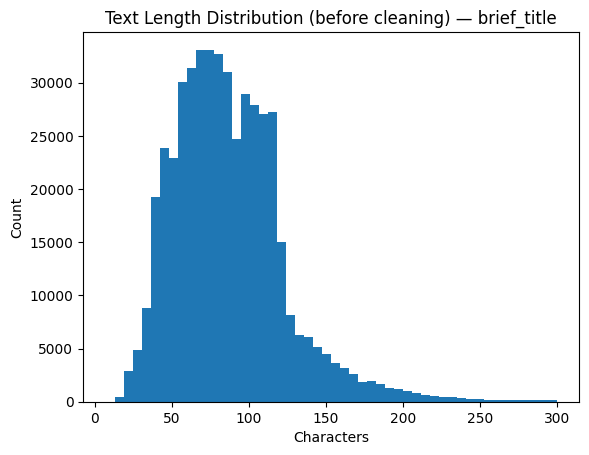

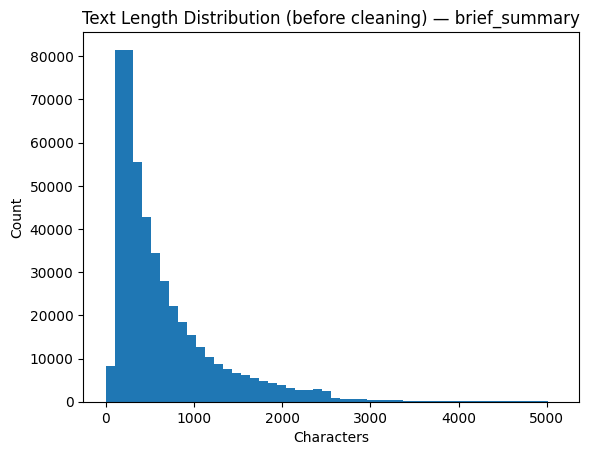

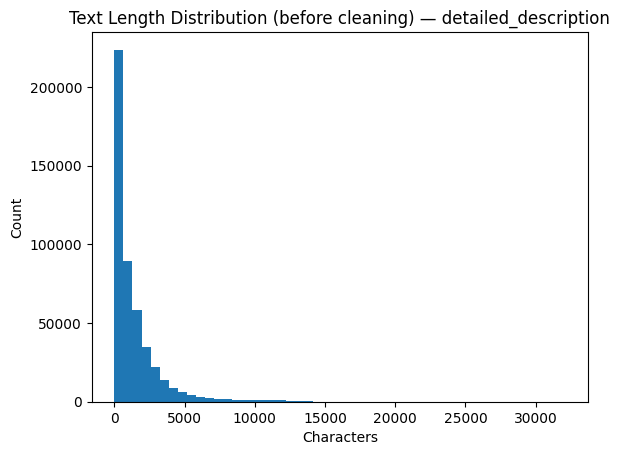

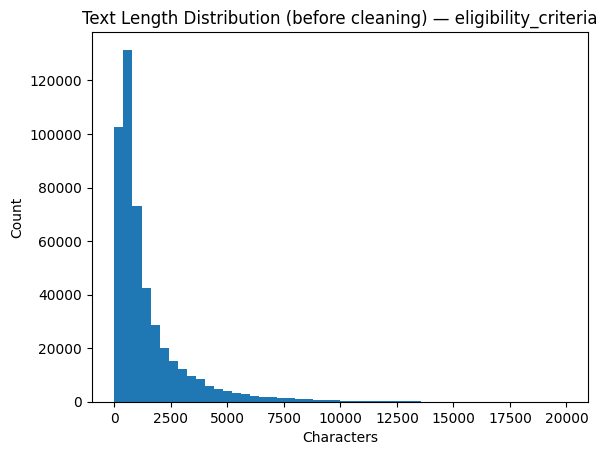

In [16]:
def length_dist_plot(state):
    text_cols = ["brief_title", "brief_summary", "detailed_description", "eligibility_criteria"]
    
    def add_length(example):
        for col in text_cols:
            example[col + "_length"] = len(example[col]) if example[col] is not None else 0 # get length of text or 0 if not present
        return example

    ds_len = train_data.map(add_length, num_proc=4) # map to apply defined length getting function

    for col in text_cols:
        plt.figure()
        plt.hist(ds_len[col + "_length"], bins=50)
        plt.title(f"Text Length Distribution ({state}) — {col}")
        plt.xlabel("Characters")
        plt.ylabel("Count")
        plt.show()

length_dist_plot("before cleaning")

We also check the keywords to get a glimpse of what are the top keywords and we also want to uncovered hidden connection `between brief_summary` and `detailed_description` features.

In [17]:
def get_text_statistics():
    def fast_tokenize(text): # simple tokenization
        if not text or not isinstance(text, str):
            return []
        return text.lower().split()

    def process_keywords(batch): # function for batches of keywords
        kws = []
        counts = []
        for entry in batch["keywords"]:
            if entry and isinstance(entry, str):
                tokens = [k.strip().lower() for k in entry.split(",") if k.strip()] # generate list of tokens if possible
            else:
                tokens = [] # otherwise empty list 
            kws.append(tokens)
            counts.append(len(tokens))
        return {"keywords_list": kws, "num_keywords": counts}

    kw_dataset = train_data.map(process_keywords, batched=True, num_proc=4) # apply keyword processing

    keyword_counter = Counter() # get keyword data from altered dataset
    for kws in kw_dataset["keywords_list"]:
        keyword_counter.update(kws)


    text_fields = ["brief_summary", "detailed_description"]

    def compute_lengths(batch): # function for batches of free text
        lengths = {f"{field}_word_count": [] for field in text_fields} # initialize multiple new computed features (columns)
        for field in text_fields:
            for record in batch[field]:
                lengths[f"{field}_word_count"].append(len(fast_tokenize(record))) # add new data to columns
        return lengths

    kw_length_dataset = kw_dataset.map(compute_lengths, batched=True) # apply computaton function to get new computed features

    x = np.array(kw_length_dataset["brief_summary_word_count"]) # caculate in numpy for efficiency
    y = np.array(kw_length_dataset["detailed_description_word_count"])

    correlation = np.corrcoef(x, y)[0, 1]  # Pearson correlation
    
    print("\n--- Keyword statistics ---")
    print(f"Average keywords per record: {np.mean(kw_length_dataset['num_keywords']):.2f}")
    print("Top 10 keywords:")
    for kw, c in keyword_counter.most_common(10):
        print(f"{kw}: {c}")

    print("\n--- Cross-field length correlation ---")
    print(f"Correlation between brief_summary and detailed_description word counts: {correlation:.4f}")

get_text_statistics()

Map (num_proc=4):   0%|          | 0/479038 [00:00<?, ? examples/s]

Map:   0%|          | 0/479038 [00:00<?, ? examples/s]


--- Keyword statistics ---
Average keywords per record: 2.80
Top 10 keywords:
": 4951
"quality of life": 2800
"pain": 2627
"depression": 2058
"exercise": 1946
"quality of life"]: 1838
["breast cancer": 1829
"safety": 1787
"obesity": 1785
"anxiety": 1769

--- Cross-field length correlation ---
Correlation between brief_summary and detailed_description word counts: 0.2675


#### Explanation

As we can see it from the plots, there is remarkable difference between each feature throughout the dataset. This yields in the following conclusion. The longer the text the longer it can contain stopwords which should be removed. The longer the text the longer it can contain words that appear in different forms. The conclusion is that with tokenization the texts should be a bit more normalized, besides the fact that tokenization is usually a step when working with free text anyway to be able to feed it to models efficiently. We can also see the top keywords and correlation between `brief_summary` and `detailed_description`, from the result we can see that there is weak correlation (Pearson correlation) between the two features (0.2 - 0.4 weak correlation). It means that the length of summary does not predict length of description, so the size of the brief summary possibly not increase when the detailed description gets longer.

### Tokenization steps:
 - stopword removal
 - lowercasing
 - lemmatization (this might change later to domain specific lemmatization (like for medical field))
 - column filtering (keep only relevant columns) *--has been done beforehand*
 - row filtering (delete rows that does not meet certain criterias) *--has been done before*
 - unified format (only plain text, no html or other modifiers)

 #### Load spacy for prepocessing text

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # initialize spaCy for advanced NLP
stopwords = nlp.Defaults.stop_words

print("NLP pipeline loaded with necessary steps.")

NLP pipeline loaded with necessary steps.


#### Making column filter for new columns in cleaned dataset

In [19]:
# define new projection columns

NEW_RELEVANT_COLS = ID_COL + list(map(lambda x: x + "_clean", FREE_TEXT_COLS + STRUCTURED_TEXT_COLS)) + VALIDATION_COLS

NEW_RELEVANT_COLS.append("combined_text")
NEW_RELEVANT_COLS.append("text_len")

print("New relevant columns:")
pprint(NEW_RELEVANT_COLS)

New relevant columns:


[
│   'nct_id',
│   'brief_title_clean',
│   'brief_summary_clean',
│   'detailed_description_clean',
│   'eligibility_criteria_clean',
│   'keywords_clean',
│   'mesh_terms_clean',
│   'condition_browse_module_clean',
│   'intervention_browse_module_clean',
│   'conditions',
│   'interventions',
│   'combined_text',
│   'text_len'
]

#### Defined functions for preprocessing text and preprocessing

The team defined some functions to tokenize and clean the data. Here these functions are utilized also.

In [20]:
html_re = re.compile(r"<.*?>")
space_re = re.compile(r"\s+")

# Cleaning function for free text to remove html and remove trailing whitespaces and lowercase it
def clean_text(x):
    if not x:
        return ""
    x = html_re.sub(" ", x)
    x = x.replace("&nbsp;", " ").replace("&amp;", "&")
    return space_re.sub(" ", x.lower()).strip()

# Function to format nested / structured text
def parse_nested_field(v):
    if isinstance(v, (dict, list)):
        return v
    try:
        return ast.literal_eval(v)
    except:
        return []

# Function to clean structured text: trim, lowercase and filter for specific keys, then join it back with space delimiter
def extract_terms(module):
    if not isinstance(module, dict):
        return ""
    out = []
    for key in ["meshes","browseLeaves","browseBranches","ancestors","conditions","interventions"]:
        items = module.get(key)
        if isinstance(items, list): # check for only valid items -> list
            for m in items:
                if isinstance(m, dict): # check for only valid items -> dictionaries
                    t = m.get("term") or m.get("name")
                    if t:
                        out.append(t.lower().strip())
    return " ".join(set(out))

# Function to format and filter keywords, split, lowercase, trim and rejoin them with space delimiter
def normalize_keywords(v):
    try:
        v = ast.literal_eval(v)
        if isinstance(v, list):
            return " ".join(str(x).lower().strip() for x in v if x)
    except:
        pass
    return str(v).lower().strip() if v else ""

# Fast text and semantic field building
def fast_clean(batch):
    # calculate cleaned features according to free text cleaning function
    titles = [clean_text(x) for x in batch["brief_title"]]
    summaries = [clean_text(x) for x in batch["brief_summary"]]
    criteria = [clean_text(x) for x in batch["eligibility_criteria"]]
    descs = [clean_text(x) for x in batch["detailed_description"]]

    # calculate cleaned features according to structured text cleaning functions
    cb = [extract_terms(parse_nested_field(x)) for x in batch["condition_browse_module"]]
    ib = [extract_terms(parse_nested_field(x)) for x in batch["intervention_browse_module"]]
    mesh = [extract_terms(parse_nested_field(x)) for x in batch["mesh_terms"]]
    keywords = [normalize_keywords(x) for x in batch["keywords"]]

    # get a combined free text field
    batch["combined_text_raw"] = [
        " ".join([titles[i], summaries[i], criteria[i], descs[i], cb[i], ib[i], mesh[i], keywords[i]]).strip()
        for i in range(len(titles))
    ]
    
    # define new features as cleaned (new columns)
    batch["brief_title_clean"] = titles
    batch["brief_summary_clean"] = summaries
    batch["eligibility_criteria_clean"] = criteria
    batch["detailed_description_clean"] = descs
    batch["condition_browse_module_clean"] = cb
    batch["intervention_browse_module_clean"] = ib
    batch["mesh_terms_clean"] = mesh
    batch["keywords_clean"] = keywords
    
    return batch

# Apply cleaning (NO spaCy yet for efficiency)
# We ran a subset here, for full dataset we ran in a separate pipeline: https://www.kaggle.com/code/peetertarvas/preprocessing-train
sample_for_showing_cleaning = train_data.select(range(6000));
processed_ds = sample_for_showing_cleaning.map(
    fast_clean,
    batched=True,
    batch_size=2000
)

# Faster spaCy lemmatization using pipe
def spacy_lemmatize_texts(texts):
    output = []
    for doc in nlp.pipe(texts, batch_size=256, n_process=4):  # <--- speed up by using it outside the map and using its multip-process capability
        output.append(" ".join(t.lemma_ for t in doc if t.text not in stopwords and t.lemma_))
    return output

# Get text from processed dataset
all_text = processed_ds["combined_text_raw"]
lemmatized = []

# Apply spaCy with progress bar in 5000 size chunks of data to avoid memory spikes
for i in tqdm(range(0, len(all_text), 5000)):
    chunk = all_text[i:i+5000]
    lemmatized.extend(spacy_lemmatize_texts(chunk))

processed_ds = processed_ds.add_column("combined_text", lemmatized)
processed_ds = processed_ds.add_column("text_len", [len(t) for t in lemmatized])

processed_ds = processed_ds.select_columns(NEW_RELEVANT_COLS)

# Save dataset to disk: ./clinical-dataset-cleaned
processed_ds.save_to_disk("clinical-dataset-cleaned")

print("Created cleaned dataset: clinical-dataset-cleaned")


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/6000 [00:00<?, ? examples/s]

Created cleaned dataset: clinical-dataset-cleaned


### Load the cleaned dataset

Load the dataset as show example first 10 rows

In [21]:
cleaned_ds = load_from_disk("/kaggle/working/data") # load dataset

train_data = cleaned_ds

cleaned_ds_pd = cleaned_ds.select(range(10)).to_pandas() # show example of dataset

cleaned_ds_pd

,nct_id,brief_title_clean,brief_summary_clean,detailed_description_clean,eligibility_criteria_clean,keywords_clean,mesh_terms_clean,condition_browse_module_clean,intervention_browse_module_clean,conditions,interventions,combined_text,text_len
0,NCT01273766,deferasirox in treating iron overload caused b...,rationale: deferasirox may remove excess iron ...,primary objectives: i. to determine the effect...,inclusion criteria: * patients must have a pat...,,myelodysplastic-myeloproliferative diseases ly...,"lymphoma, non-hodgkin waldenstrom macroglobuli...",deferasirox molecular mechanisms of pharmacolo...,"[Acute Undifferentiated Leukemia, Adult Acute ...",None,deferasirox treat iron overload cause blood tr...,6632
1,NCT00787566,"phase 2 study of efficacy, tolerability, and s...","brief summary: a randomized, single administra...",,inclusion criteria: * patients with histologic...,highly emetogenic chemotherapy induced nausea ...,granisetron vomiting nausea,symptoms and general pathology nausea signs an...,molecular mechanisms of pharmacological action...,[Chemotherapy-Induced Nausea and Vomiting],None,"phase 2 study efficacy , tolerability , safety...",3332
2,NCT00497666,association between rosiglitazone use and clin...,recent data show that rosiglitazone treatment ...,background type 2 diabetes mellitus is a publi...,inclusion criteria: 1. diagnosis of diabetes m...,diabetes diabetic nephropathy renal protection,diabetic nephropathies kidney diseases disease...,diabetes mellitus symptoms and general patholo...,all drugs and chemicals hypoglycemic agents ro...,"[Diabetes, Diabetic Nephropathy, Renal Protect...",None,association rosiglitazone use clinical course ...,13450
3,NCT01978366,open label extension study of ht-100 in patien...,this study is designed to provide 6-months con...,,inclusion criteria: * completed both the singl...,duchenne muscular dystrophy halofuginone hydro...,"muscular dystrophies muscular dystrophy, duche...",rare diseases muscular dystrophies genetic dis...,growth inhibitors antineoplastic agents anti-i...,[Duchenne Muscular Dystrophy],None,open label extension study ht-100 patient dmd ...,2046
4,NCT04912466,ibi322 monotherapy or combination therapy in s...,the phase ia study was designed to evaluate th...,,inclusion criteria: 1. histologically/cytologi...,,neoplasms,neoplasms,immunoglobulins all drugs and chemicals antibo...,[Advanced Solid Tumor],None,ibi322 monotherapy combination therapy subject...,1550
5,NCT03409666,randomized controlled rsa study comparing the ...,"this is a single center, prospective, randomiz...",a total of 50 patients will be enrolled into t...,inclusion criteria: * non-inflammatory degener...,total hip arthroplasty medical device performa...,"joint diseases necrosis osteoarthritis, hip os...",joint diseases necrosis rheumatic diseases sym...,,"[Hip Osteoarthritis, Noninflammatory Degenerat...",None,randomize control rsa study compare taperloc c...,1704
6,NCT00622466,sorafenib and paclitaxel in treating patients ...,rationale: sorafenib may stop the growth of tu...,objectives: primary * to evaluate the efficacy...,disease characteristics: inclusion criteria: *...,stage iv breast cancer male breast cancer recu...,paclitaxel breast neoplasms sorafenib,"breast neoplasms, male rare diseases breast di...",antineoplastic agents albumin-bound paclitaxel...,[Breast Cancer],None,sorafenib paclitaxel treat patient metastatic ...,5512
7,NCT04868266,end tidal carbon dioxide in minimal sedation,this randomized controlled study investigated ...,,inclusion criteria: * pediatric patients under...,,,symptoms and general pathology all conditions ...,,[Complication of Anesthesia],None,end tidal carbon dioxide minimal sedation rand...,316
8,NCT06147466,time spent in target glucose range in women wi...,prospective cohort study to determine to what ...,,inclusion criteria: 1. women with type 2 diabe...,glucose range neonatal outcomes glycemic contr...,"pregnancy in diabetics diabetes mellitus, type..

In [22]:
pprint(cleaned_ds.features) # show features

{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64')
}

### Considerations

The primary objective of the team was to run the defined pipeline as fast as possible, memory efficiency was the second consideration. Thats why most of the implementation uses the huggingface datasets library, which gives the possibility to run C++ implementations "under the hood" for faster execution. Batching and multiple processing abilities were utilised where it was possible. These improvements lead us to the result of decreasing the pipeline time from hour long execution to only some minutes or seconds (fastest iteration on dataset is some seconds, slowest with the hihghest complexity is 5 minutes). However the preprocessing's final output takes 3 hours because of the spaCy nlp pipeline which 3 hours is still the most efficient we could do (used it outside of map of dataset with the multiprocessing capability).

# Anchored Topic Modeling for Interpretable Clinical Trial Landscapes

This notebook corresponds to Phase 1: Data Familiarization and Preprocessing of our project.
We load and explore the Clinical Trials dataset from Hugging Face, inspect fields, and clean/structure data for embedding and anchor-guided topic modeling.
Next stages (embedding, anchored clustering, evaluation) will build upon this preprocessing pipeline.

---

### Planned Methods

Each clinical trial will be represented as a dense semantic embedding vector:

$$
x_i = f_{\theta}(T_i)
$$

where theta is a transformer-based encoder such as **BioClinicalBERT** or **Sentence-BERT**,
and  Ti is the cleaned textual description of a trial.

---

To incorporate medical interpretability, we embed domain-specific anchor terms aj in the same semantic space.
Cluster membership is then softly guided by proximity to these anchors:

$$
w_{ij} =
\frac{
    \exp \left( -\frac{\| x_i - a_j \|^2}{\tau} \right)
}{
    \sum_k \exp \left( -\frac{\| x_i - a_k \|^2}{\tau} \right)
}
$$

where tau controls how strongly anchors influence topic assignment.

---

This approach encourages trials semantically close to a medical anchor
(Oncology, Cardiology) to be grouped into interpretable, domain-aligned clusters.


# Milestone P3 - Training pipeline

### Imports

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
import re
import json

from transformers import AutoTokenizer, AutoModel, AutoConfig
from datasets import load_from_disk
from sklearn.cluster import KMeans
from safetensors.torch import load_file
from rich.pretty import pprint
import torch.nn.functional as F
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, normalized_mutual_info_score

print("Extrenal libraries imported")

2025-12-20 08:55:46.284133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766220946.465391      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766220946.515921      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766220946.940910      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766220946.940940      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766220946.940942      24 computation_placer.cc:177] computation placer alr

Extrenal libraries imported


### Setting dataset path for importing data

In [24]:
path_to_ds = "/kaggle/working/data" # your path to the dataset

print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "/kaggle/working/data"


### Importing dataset

In [ ]:
if os.path.exists(path_to_ds): # load from disk if present, otherwise download it from HF
    ds_full = load_from_disk(path_to_ds)
else:
    ds_full = load_dataset("Kornimate/medical-research-clean-v2", split="train")
    ds_full.save_to_disk(path_to_ds)

print("Dataset loaded successfully")

# may need to: ds_full= ds_full["train"]

print("Dataset:")
pprint(ds_full.features)
print(ds_full.num_rows)

Dataset loaded successfully
Dataset:


{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64')
}

479038


### Importing and setting up model and tokenizer for embedding generation

In this part the model loading is happening, either from the device or from the internet, we used a domain specific model for medical data to generate better embeddings for our medical terms heavy dataset

In [26]:
model = None
tokenizer = None

# model, has domain knowledge of textuatl data that contains medial terms
# due to domain knowledge it can generate better embeddings
model_name = "emilyalsentzer/Bio_ClinicalBERT" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use GPU if possible

if os.path.isdir("./model_saved"): # if model is present on device, use that
    print("Model and Tokenizer on disk")
    
    tokenizer = AutoTokenizer.from_pretrained("./model_saved")
    model = AutoModel.from_pretrained("./model_saved").to(device)

else: # if model is not there, load as much of it as possible and the rest from a safetensors conversion (here due to compatibility we used python 3.10 and the last load_file on this python version had issues with normal model load withput safetensors convert)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval() # set model to selected device

print(model.eval())

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Constants fore embedding generation

In [27]:
MAX_LEN = 256
TEXT_FIELD_FOR_EMBEDDING = "combined_text"
SEED = 42

### Functions for emedding generation

These functions are used to generate and normalize embeddings for clustering, L-2 normalization enables us to be able to use Spherical KMeans as that version of KMeans fits for high dimensional data do avoid curse of dimensionality (distance become meaningless in high dimensions).

In [ ]:
# mean pooling on token embeddings, ignores padding tokens.
def mean_pool(last_hidden_state, attention_mask):

    # expand mask to match embedding dimensions
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    masked = last_hidden_state * mask # null (zero value) out embeddings which are padding tokens

    summed = masked.sum(1) # sum embeddings across the length dimension

    # number of not padding tokens in each sequence
    # clamping -> division by zero problem solution
    counts = mask.sum(1).clamp(min=1e-9)

    return summed / counts # mean

# generate embeddings for batch
def embed_batch(batch):
    texts = batch[TEXT_FIELD_FOR_EMBEDDING] # input

    enc = tokenizer( # tokenizer
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    with torch.no_grad():
        enc = {k: v.to(device) for k, v in enc.items()} # move to device

        outputs = model(**enc) # embeddings

        pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])

        # L2 normalization of embeddings -> cosine similarity usage (needed for KMeans to use as Spherical KMeans due to high dim data (curse of dim))
        pooled = F.normalize(pooled, p=2, dim=1)

        embeddings = pooled.cpu().numpy()

    batch["embedding"] = [e.astype(np.float32) for e in embeddings]

    return batch


### Run the embedding generation

In [29]:
ds = load_from_disk("/kaggle/working/data")
DEV_SIZE = 100
ds_dev_for_embeddings = ds.shuffle(seed=42).select(range(min(DEV_SIZE, len(ds))))

ds_dev_emb = ds_dev_for_embeddings.map(
    embed_batch,
    batched=True,
    batch_size=128 # adjust this to device: CPU: 32-64, GPU: 64-256+ -> based on VRAM 
) # use datasets map for faster implementation
# This is example of work, we generated dataset in separate pipeline here: https://www.kaggle.com/code/peetertarvas/embeddings

print("Dataset with embeddings:")
pprint(ds_dev_emb.features)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset with embeddings:


{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64'),
│   'embedding': List(Value('float32'))
}

### Save dataset

In [30]:
ds_dev_emb.save_to_disk("clinical-dataset-cleaned-with_embeddings")

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

### First checkpoint of dataset

As we progress in this notebook, the "high volume" calculations impose a risk of the environment to collapse as nothing is perfect. Thats why we introduce checkpoints to save the dataset and the progress so far, in this case if we want to get here, we can run only specific cells without the heavy calculations and can continue out progress. Each checkpoint consists of saving the dataset, then with some extarnal script we upload it to huggingface for distribution to other notebook runners (otherwise just load it from disk). At each checkpoint we will provide a link to the generated dataset.

### Set path

In [31]:
!cp -r /kaggle/input/embeddings-dataset/clinical_trials_with_embeddings /kaggle/working/data_2

In [32]:
path_to_ds = "/kaggle/working/data_2" # your path to the dataset


print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "/kaggle/working/data_2"


### Load dataset

In [ ]:
if os.path.exists(path_to_ds): # load from disk if present, otherwise download it from HF
    ds_dev_emb = load_from_disk(path_to_ds)
else:
    ds_dev_emb = load_dataset("Kornimate/medical-research-clean-embeddings", split="train")
    ds_dev_emb.save_to_disk(path_to_ds)

print("Dataset loaded successfully")

# may need to: ds_dev_emb = ds_dev_emb["train"]

print("Dataset:")
pprint(ds_dev_emb.features)
print(ds_dev_emb.num_rows)
print("Example: first element's first 10 dimensions")
pprint(ds_dev_emb[0]["embedding"][:10]) # example

Dataset loaded successfully
Dataset:


{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64'),
│   'embedding': List(Value('float32'))
}

479038
Example: first element's first 10 dimensions


[
│   0.0038159817922860384,
│   -0.016568316146731377,
│   -0.023192480206489563,
│   0.019206879660487175,
│   0.010358400642871857,
│   0.002639321144670248,
│   -0.005096878856420517,
│   0.008081996813416481,
│   0.02565639652311802,
│   -0.0006236047483980656
]

### Train / test split:

In our case since, the task is generalization it makes sense to split the dataset into train and test data (however it is not supervised learning), but wihtout it is hard to tell if topics generalize. The split will be 80/20. The train part will be used for geometry of clusters definiton, while test will be used for interpretation and evaluation.

In [34]:
ds = ds_dev_emb.shuffle(seed=SEED).select(range(300_000)) # shuffle to sample correctly, show on smaller subset for kaggle runtime
train_size = int(0.8 * ds.num_rows) # 80% train ds

ds_train = ds.select(range(train_size))
ds_test  = ds.select(range(train_size, ds.num_rows))

### Anchors

Now that the embeddings are generated for the dataset, the task shifts to generating embeddings for anchors. The embeddings for anchors have to be similarly generated as the embeddings for the dataset in order to be able to influence the dataset embeddings during anchored topic modelling. The creation of acnhored topics was made in a separate file which can be found in the repository: scripts/anchor-generation.ipynb -> which is the first task. Selection of topics and top keywords for them. 

### Anchored topics import

As the long running process of creating the anchored topics was run on an external script that can be found in the repository (). The resulst must be imported

### Set Path

In [35]:
path_to_anchors = "/kaggle/input/anchors2/anchor_groups_cleaned.json" # your path to the dataset

print(f"Path is set to: \"{path_to_anchors}\"")

Path is set to: "/kaggle/input/anchors2/anchor_groups_cleaned.json"


### Load anchors

In [ ]:
if os.path.exists(path_to_anchors):
    with open(path_to_anchors) as f:
        ANCHOR_GROUPS = json.load(f)
else:
    raise ValueError("Anchors must be reachable from the environment!")

print("Anchors loaded successfully")

print(ANCHOR_GROUPS['1']) # example

Anchors loaded successfully
['insulin', 'other', 'substitutes', 'hematinics', 'b', 'antibiotics', 'vaccines', 'zinc', 'lipid', 'c', 'complex', 'globin', 'd', 'folate', 'iron', 'estradiol', 'diuretics', 'tannic', 'coagulants', 'bupivacaine', 'angiotensin', 'metformin', 'heparin', 'antioxidants', 'potassium', 'estrogens', 'alcohol', 'interferons', 'toxins', 'ophthalmic', 'peptide', 'testosterone', 'sparing', 'calciferol', 'chlorhexidine', 'selective', 'hemostatics', 'iodine', 'retinol', 'glucagon', 'nicotine', 'citric', 'antimalarials', 'atorvastatin', 'incretins', 'beta-cypionate', 'ritonavir', 'emtricitabine', 'ribavirin', 'alfa', 'vaccine', 'interferon-alpha', 'pancrelipase', 'sulfate', 'complement', 'abobotulinumtoxina', 'aspart', 'peginterferon', 'metronidazole', 'hexacetonide', 'angiotensinogen', 'arginine', 'lamivudine', 'gout', 'giapreza', 'amoxicillin', 'peptide-1', 'sodium-glucose', 'omega', '21-propionate', 'plasminogen', 'enoxaparin', 'radiopharmaceuticals', 'tranexamic', 'va

### Generating anchor embeddings : functions
Generate anchor embeddings similarly to dataset embeddings, but we have to look out for an important factor. As these are words after each other if naively we just join them and generate an embedding for that we create an "artifical" context which would mean that these words should appear after each other which is not the case at all. So we apply something called vector averaging which means we generate embedding for each keyword in each group and then average over these keywords embeddings which creates an embedding for a group. In this way we avoided the artifical context phenomenon and could generate more meaningful embeddings.

In [ ]:

# list of keywords -> embeddings using mean pooling over token embeddings
def encode_texts(texts):

    # setup tokenizer similar to ds embedding generation
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    with torch.no_grad():
        enc = {k: v.to(device) for k, v in enc.items()} # inputs to device

        # generate embeddings
        outputs = model(**enc)

        pooled = mean_pool(
            outputs.last_hidden_state,
            enc["attention_mask"]
        )

    return pooled.cpu().numpy() # to numpy for efficient implementation


### Run the embedding generation
Vector averaging is applied here alongside normalizations: these have the following mathematical background:
$$
\begin{aligned}
\textbf{Keyword normalization:}\quad
\hat{\mathbf{e}}_k
&=
\frac{\mathbf{e}_k}{\lVert \mathbf{e}_k \rVert_2}
\\[8pt]
\textbf{Keyword averaging to form the topic anchor:}\quad
\mathbf{a}
&=
\frac{1}{K}
\sum_{k=1}^{K}
\hat{\mathbf{e}}_k
\\[8pt]
\textbf{Anchor normalization for spherical KMeans:}\quad
\hat{\mathbf{a}}
&=
\frac{\mathbf{a}}{\lVert \mathbf{a} \rVert_2}
\end{aligned}
$$

where these symbols mean the following:
- $ \mathbf{e}_k $: embedding of keyword $k$
- $ K $: number of keywords in a topic
- $ \mathbf{a} $: unnormalized topic anchor
- $ \hat{\mathbf{a}} $: final unit-norm anchor embedding
  
Normalizing is neccessary to avoid biasing anchors toward keywords with larger embedding norms.

In [ ]:
anchor_labels = list(ANCHOR_GROUPS.keys())
all_anchor_embs = []

for label in anchor_labels:
    keywords = ANCHOR_GROUPS[label]

    keyword_embs = encode_texts(keywords) # embedding gen

    # normalize keyword embeddings
    keyword_embs /= np.linalg.norm(keyword_embs, axis=1, keepdims=True)

    topic_anchor_emb = keyword_embs.mean(axis=0) # average keyword embeddings -> topic anchor

    # normalize topic anchor -> Spherical KMeans
    topic_anchor_emb /= np.linalg.norm(topic_anchor_emb)

    all_anchor_embs.append(topic_anchor_emb)

# anchor matrix
anchor_embs = np.stack(all_anchor_embs, axis=0)


### Clustering

For our project (Anchorder Topic Modelling), we use unsupervised learning in the form of KMeans. As the data is high dimensional simple distance-based KMeans would not be good due to curse of dimensionality (distances become meaningless in high dimensions) so we use it in a form of spherical KMeans which is an angle based approach which should work well in higher dimensions as well. Here by normalizing the embeddings we basically put them into the cosine space (embeddings on the n-dimensional unit sphere). We also state that euclidean distance on L2-normalized vectors (anchor embeddings also) is same as to cosine distance -> thats why KMeans on euclidean distance effectively becomes Spherical KMeans on normalized vectors.

Mathematical equvivalence:
$$
\begin{aligned}
\|x - c\|^2 
&= (x - c)\cdot(x - c) \\
&= x\cdot x + c\cdot c - 2x\cdot c \\
&= 1 + 1 - 2(x\cdot c) \\
&= 2\bigl(1 - \text{cosine\_similarity}(x, c)\bigr)
\end{aligned}
$$
 -> minimizing euclidean distance is equal to maximizing cosine similarity -> doing KMeans on normalized embeddings $=$ do cosine-based clustering

Since cosine similarity in high dimension is stable and meaningful while if we have used sth distance based like HDBSCAN we may have reduced dimensionality (with e.g. UMAP) which will create less meaningful embeddings. So we decided on KMeans because of it (as it needs more tuning because we have to specify the clusters in advance -> had a strategy for that too (K = A + E, can be seen in python cell)), settings max iterations. Selecting the initial centroids is basically using the topics embeddings and extend it with random ones from dataset (maybe this could be improved by selecting embeddings from ds with low similarity to anchor embeddings to nicely model extra clusters).

In [39]:
X = np.vstack(ds_train["embedding"]).astype(np.float32)

# normalize to unit length (cosine → euclidean equivalence)
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True) # K-Means over L2-normalized vectors = Spherical K-Means.

# IF anchor_embs ARE NOT NORMALIZED DO IT HERE
anchor_centroids = anchor_embs # already in cosine space
A = anchor_centroids.shape[0]

E = 20  # E between 80-120 when working with whole dataset
K = A + E # topics and extra clusters

# get extra centroids from the data
rng = np.random.default_rng(SEED)
extra_idx = rng.choice(X_norm.shape[0], size=E, replace=False)
extra_centroids = X_norm[extra_idx]

init_centroids = np.vstack([anchor_centroids, extra_centroids])

kmeans = KMeans(
    n_clusters=K,
    init=init_centroids,
    n_init=1,           # important: we already gave centroids
    max_iter=300,
    random_state=SEED
)

cluster_labels_kmeans = kmeans.fit_predict(X_norm)

# renormalize learned centroids (needed for spherical behaviour as centroids should live on the unit hypersphere -> cosine space)
centers = kmeans.cluster_centers_
centers = centers / np.linalg.norm(centers, axis=1, keepdims=True)

ds_train = ds_train.add_column(
    "cluster_kmeans_anchored",
    cluster_labels_kmeans.tolist()
)

Flattening the indices:   0%|          | 0/240000 [00:00<?, ? examples/s]

### Get list of clusters predicted by KMeans

In [40]:
unique_vals = set(ds_train["cluster_kmeans_anchored"])
print(unique_vals)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


### Save dataset

In [41]:
ds_train.save_to_disk("clinical-dataset-cleaned-with_embeddings-with_clusters")

Saving the dataset (0/5 shards):   0%|          | 0/240000 [00:00<?, ? examples/s]

### Save centroids

In [42]:
os.makedirs("kmeans-model", exist_ok=True)

np.save("kmeans-model/model.npy",centers)
    
print("centroids saved")

centroids saved


### 2. Checkpoint

### Set path

In [43]:
path_to_ds = "clinical-dataset-cleaned-with_embeddings-with_clusters" # your path to the dataset

print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "clinical-dataset-cleaned-with_embeddings-with_clusters"


### Load dataset

In [ ]:
if os.path.exists(path_to_ds):
    ds_train = load_from_disk(path_to_ds)
else:
    raise ValueError("Dataset must be reachable from the environment!")

print("Dataset loaded successfully")

print("Dataset:")
print(ds_train.features)
print(ds_train.num_rows)
print("Example: first element's first 10 dimensions")
print(ds_train[0]["embedding"][:10]) # example

Dataset loaded successfully
Dataset:
{'nct_id': Value('string'), 'brief_title_clean': Value('string'), 'brief_summary_clean': Value('string'), 'detailed_description_clean': Value('string'), 'eligibility_criteria_clean': Value('string'), 'keywords_clean': Value('string'), 'mesh_terms_clean': Value('string'), 'condition_browse_module_clean': Value('string'), 'intervention_browse_module_clean': Value('string'), 'conditions': List(Value('string')), 'interventions': Value('null'), 'combined_text': Value('string'), 'text_len': Value('int64'), 'embedding': List(Value('float32')), 'cluster_kmeans_anchored': Value('int64')}
240000
Example: first element's first 10 dimensions
[-0.007704603020101786, -0.015694493427872658, -0.01875792257487774, -0.005578143056482077, 0.0018089351942762733, -0.007056606002151966, -0.005387282930314541, 0.008203675039112568, 0.008357904851436615, 0.028743796050548553]


### Load centroids

In [45]:
centers = np.load("kmeans-model/model.npy")

### Clustering visualization

using umap, which applies dimensionality reduction to be able to visualize it in matplotlib

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


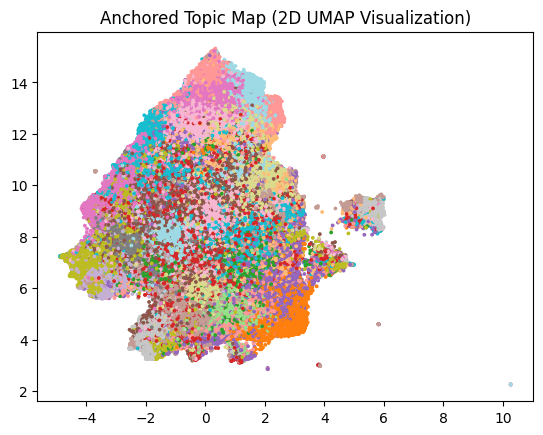

In [46]:
umap_vis = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine", random_state=SEED)
X_2d = umap_vis.fit_transform(X_norm)

plt.scatter(X_2d[:,0], X_2d[:,1], c=cluster_labels_kmeans, s=3, cmap="tab20")
plt.title("Anchored Topic Map (2D UMAP Visualization)")
plt.show()

### Assign clusters to test split using frozen centroids 

Now that we have the clustering, based on this using the frozen centroids, we can assing test data to centroids and compute their clusters using cosine similarity (we are in cosine space)

In [47]:
X_test = np.vstack(ds_test["embedding"])
X_test_norm = X_test / np.linalg.norm(X_test, axis=1, keepdims=True) # put into cosine space, have same transformations ans ds_train

sim = cosine_similarity(X_test_norm, centers)
test_cluster_labels = sim.argmax(axis=1)

ds_test = ds_test.add_column( # adding feature to ds_test
    "cluster_kmeans_anchored",
    test_cluster_labels
)

Flattening the indices:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [48]:
print(set(ds_test["cluster_kmeans_anchored"]))

{0, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


### Save clustering of test split for evaluation

In [49]:
ds_test.save_to_disk("clinical-dataset-cleaned-with_embeddings-with_clusters-eval")

Saving the dataset (0/2 shards):   0%|          | 0/60000 [00:00<?, ? examples/s]

### 3. Checkpoint

### Set path

In [50]:
path_to_ds = "clinical-dataset-cleaned-with_embeddings-with_clusters-eval" # your path to the dataset

print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "clinical-dataset-cleaned-with_embeddings-with_clusters-eval"


### Load dataset

In [ ]:
if os.path.exists(path_to_ds): # load from disk if present, otherwise download it from HF
    ds_test = load_from_disk(path_to_ds)
else:
    raise ValueError("Dataset must be reachable from the environment!")

print("Dataset loaded successfully")

print("Dataset:")
pprint(ds_test.features)
print(ds_test.num_rows)
print("Example: clusters of first 10 elements")
pprint(ds_test["cluster_kmeans_anchored"][:10]) # example

Dataset loaded successfully
Dataset:


{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64'),
│   'embedding': List(Value('float32')),
│   'cluster_kmeans_anchored': Value('int64')
}

60000
Example: clusters of first 10 elements


[21, 32, 12, 26, 4, 4, 26, 14, 30, 26]

### Compute soft anchor similarity weights for each research
It gives a probability distribution over anchors for each research input, this will be used later for descriptive metrics 

In [52]:
sims = cosine_similarity(X_test, anchor_embs)
sims_std = (sims - sims.mean(axis=0)) / sims.std(axis=0)

tau = 0.1
weights = np.exp(sims_std / tau)
weights = weights / weights.sum(axis=1, keepdims=True)

### Post-anchoring function

Now that the researches are assigned to clusters, we can can move on to assigning topics to clusters. Here each cluster will be assigned a dominant cluster. We also prepared for weak cases too, then "other" will be returned. Its important to line out that here the clustering geometry is alreay fixed, so we dont change the geometry, just assign the cluster a topics that best describes it. This cell describes a function for it. We also apply standardization to similarty matrix to battle the problem of broad vs. narrow anchors (broad will dominate -> anchor comparison is unfair) 

In [ ]:
def post_anchor_clusters(
    X,
    cluster_labels,
    anchor_embs,
    anchor_labels,
    anchor_threshold=0.55,
    other_label="other"
):
    sim_matrix = cosine_similarity(X, anchor_embs)
    
    unique_clusters = sorted(c for c in np.unique(cluster_labels))

    sim_std = (sim_matrix - sim_matrix.mean(axis=0)) / sim_matrix.std(axis=0) # column-wise standardization of the anchor similarity matrix
    
    cluster_anchor_scores = {} # store sim score per cluster
    final_cluster_labels = {} # final labels to clusters

    for c in unique_clusters:
        mask = (cluster_labels == c) # Mask of samples in the current cluster

        mean_scores = sim_std[mask].mean(axis=0) # mean similarity to anchors for given cluster
        cluster_anchor_scores[c] = mean_scores

        # selecting best anchor
        best_idx = np.argmax(mean_scores)
        best_score = mean_scores[best_idx]

        if best_score >= anchor_threshold: # Assign anchor label only if value bigger than threshold,
            final_cluster_labels[c] = anchor_labels[best_idx]
        else: # otherwise "other"
            final_cluster_labels[c] = other_label

    # make the research labeling based on cluster assigned topics
    assigned_topics = []
    for lbl in cluster_labels:
        assigned_topics.append(final_cluster_labels[lbl])

    return assigned_topics, final_cluster_labels, cluster_anchor_scores


### Run the post-anchoring function

In [54]:
topics_anchored, anchor_map, anchor_scores = post_anchor_clusters(
    X=X_test,                               
    cluster_labels=test_cluster_labels,   
    anchor_embs=anchor_embs,                
    anchor_labels=anchor_labels,            
    anchor_threshold=0.55 # tuneable
)

ds_test = ds_test.add_column("topic_anchored_test_t", topics_anchored) # add to dataset

### Save dataset

In [55]:
ds_test.save_to_disk("clinical-dataset-cleaned-with_embeddings-with_clusters-with_topics-eval")

Saving the dataset (0/2 shards):   0%|          | 0/60000 [00:00<?, ? examples/s]

### 4. Checkpoint

### Set path

In [56]:
path_to_ds = "clinical-dataset-cleaned-with_embeddings-with_clusters-with_topics-eval" # your path to the dataset

print(f"Path is set to: \"{path_to_ds}\"")

Path is set to: "clinical-dataset-cleaned-with_embeddings-with_clusters-with_topics-eval"


### Load dataset

In [ ]:
if os.path.exists(path_to_ds):
    ds_train = load_from_disk(path_to_ds)
else:
    raise ValueError("Dataset must be reachable from the environment!")

print("Dataset loaded successfully")

print("Dataset:")
pprint(ds_train.features)
print(ds_train.num_rows)
print("Example: first 10 elements topics")
pprint(ds_train["topic_anchored_test_t"][:10]) # example

Dataset loaded successfully
Dataset:


{
│   'nct_id': Value('string'),
│   'brief_title_clean': Value('string'),
│   'brief_summary_clean': Value('string'),
│   'detailed_description_clean': Value('string'),
│   'eligibility_criteria_clean': Value('string'),
│   'keywords_clean': Value('string'),
│   'mesh_terms_clean': Value('string'),
│   'condition_browse_module_clean': Value('string'),
│   'intervention_browse_module_clean': Value('string'),
│   'conditions': List(Value('string')),
│   'interventions': Value('null'),
│   'combined_text': Value('string'),
│   'text_len': Value('int64'),
│   'embedding': List(Value('float32')),
│   'cluster_kmeans_anchored': Value('int64'),
│   'topic_anchored_test_t': Value('string')
}

60000
Example: first 10 elements topics


['other', '4', 'other', '15', 'other', 'other', '15', '16', '11', '15']

## Evaluation: metrics for measuring anchoring and clustering quality

Starting with measures that measure clustering quality

#### Silhouette Score

 - measures how similar a data point is to its own cluster compared to other clusters  
 - ranges from **−1 to 1**, where higher values mean better cluster definitons.

For each sample $i$:

- $ a_i $: average distance between  $i$ and all other points in the same cluster  
- $ b_i $: minimum average distance between $i$ and points in a different cluster  

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

The overall silhouette score is the mean of $s_i$ over all samples:

$$
\text{Silhouette} = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

#### Calinski–Harabasz Score

 - evaluates clustering by comparing **between-cluster dispersion** and **within-cluster dispersion**.  
 - higher values indicate better clustering.

$$
\text{CH} = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \times \frac{n - k}{k - 1}
$$

Where:
- $n$: number of samples  
- $k$: number of clusters  
- $\text{Tr}(B_k)$: trace of the between-cluster dispersion matrix  
- $\text{Tr}(W_k)$: trace of the within-cluster dispersion matrix  

#### Davies–Bouldin Score

 - measures the average similarity between each cluster and its most similar cluster.  
 - lower values indicate better clustering.

For clusters $i$ and $j$:

- $S_i$: average distance of points in cluster $i$ to its centroid  
- $M_{ij}$: distance between centroids of clusters $i$ and $j$

$$
R_{ij} = \frac{S_i + S_j}{M_{ij}}
$$

The score:

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} R_{ij}
$$

In [58]:
sil = silhouette_score(X_test_norm, test_cluster_labels)
ch  = calinski_harabasz_score(X_test_norm, test_cluster_labels)
db  = davies_bouldin_score(X_test_norm, test_cluster_labels)

print(f"Silhouette Score:        {sil:.4f}")
print(f"Calinski-Harabasz Score: {ch:.2f}")
print(f"Davies-Bouldin Score:    {db:.4f}")

Silhouette Score:        0.0273
Calinski-Harabasz Score: 795.74
Davies-Bouldin Score:    3.3451


We move on with metrics measuring the anchor's quality and related properties

### Anchor coverage: How many documents strongly match ANY anchor?


 - measures the proportion of researches that are strongly aligned with at least one anchor  
 - every research has a vector of anchor weights -> max weight determines its strongest alignment

Let:
- $W \in \mathbb{R}^{n \times k}$ be the anchor-weight matrix  
- $W_{i,j}$ be the weight of research $i$ for anchor $j$  
- $n$ be the number of researches  
- $\tau$ be a predefined threshold

For each research $i$, compute the maximum anchor weight:

$$
m_i = \max_j W_{i,j}
$$

A research is considered **strongly aligned** if:

$$
m_i \ge \tau
$$


The **anchor coverage** is some fraction of researches whose max anchor weight exceeds the given threshold:

$$
\text{AnchorCoverage} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}(m_i \ge \tau)
$$

A suitable interpretation of this score is that if its between 35-70% we consider it balanced and thats why good

In [59]:
max_w = weights.max(axis=1)
threshold = 0.50

anchor_coverage = (max_w >= threshold).mean()

print("\n----- Anchor Coverage -----")
print(f"Researches strongly aligned with some anchor: {anchor_coverage:.1%}")


----- Anchor Coverage -----
Researches strongly aligned with some anchor: 25.7%


### Cluster anchor purity: Does each cluster correspond clearly to one anchor?

 - evaluates how coherent each cluster is w.r.t. a set of predefined anchors.  
 - cluster is pure if the contained researches may strongly align with a one dominant anchor.

Let:
- $n$ be the number of researches  
- $k$ be the number of anchors  
- $C$ be the set of clusters  
- $W \in \mathbb{R}^{n \times k}$ be the anchor-weight matrix  
- $z_i$ be the cluster assignment of research $i$

For a given cluster $c \in C$, compute the mean anchor weights over all researches contained by that cluster:

$$
\bar{w}_{c,j} = \frac{1}{|c|} \sum_{i : z_i = c} W_{i,j}
$$

where $|c|$ is the number of researches in cluster $c$.

The best anchor for cluster $c$ is the anchor with the highest mean weight:

$$
j^*_c = \arg\max_j \bar{w}_{c,j}
$$

The cluster anchor purity is the following:

$$
\text{Purity}(c) = \bar{w}_{c, j^*_c}
$$

This value represents how strongly, on average, the researches in $c$ align with their dominant anchor.

To summarize purity across all clusters, compute the average:

$$
\text{AvgPurity} = \frac{1}{|C|} \sum_{c \in C} \text{Purity}(c)
$$

In [60]:
def cluster_anchor_purity(cluster_labels, weights, anchor_labels):
    unique_clusters = sorted(np.unique(cluster_labels))
    results = {}

    for c in unique_clusters:
        mask = (cluster_labels == c)
        
        mean_w = weights[mask].mean(axis=0) # mean anchor weights across samples in the cluster

        best_idx = mean_w.argmax() # anchor with max meann weight

        purity = float(mean_w[best_idx]) # highest mean anchor weight

        results[c] = {
            "best_anchor": anchor_labels[best_idx],
            "purity": purity,
            "mean_weights": mean_w
        }

    return results

purities = cluster_anchor_purity(test_cluster_labels, weights, anchor_labels)

avg_purity = np.mean([v["purity"] for v in purities.values()])

print("\n----- Cluster Anchor Purity -----")
print(f"Average anchor purity across clusters: {avg_purity:.3f}\n")

for c, info in list(purities.items()):
    print(f"Cluster {c}: {info['best_anchor']} (purity={info['purity']:.3f})")



----- Cluster Anchor Purity -----
Average anchor purity across clusters: 0.263

Cluster 0: 0 (purity=0.675)
Cluster 3: 13 (purity=0.824)
Cluster 4: 13 (purity=0.205)
Cluster 5: 13 (purity=0.172)
Cluster 7: 16 (purity=0.229)
Cluster 8: 14 (purity=0.130)
Cluster 9: 8 (purity=0.276)
Cluster 11: 3 (purity=0.117)
Cluster 12: 13 (purity=0.184)
Cluster 13: 13 (purity=0.275)
Cluster 14: 16 (purity=0.649)
Cluster 15: 16 (purity=0.146)
Cluster 16: 13 (purity=0.267)
Cluster 17: 0 (purity=0.116)
Cluster 18: 0 (purity=0.126)
Cluster 19: 16 (purity=0.126)
Cluster 20: 13 (purity=0.194)
Cluster 21: 4 (purity=0.235)
Cluster 22: 3 (purity=0.200)
Cluster 23: 16 (purity=0.403)
Cluster 24: 16 (purity=0.309)
Cluster 25: 13 (purity=0.171)
Cluster 26: 15 (purity=0.185)
Cluster 27: 10 (purity=0.133)
Cluster 28: 7 (purity=0.119)
Cluster 29: 13 (purity=0.160)
Cluster 30: 0 (purity=0.179)
Cluster 31: 8 (purity=0.260)
Cluster 32: 4 (purity=0.211)
Cluster 33: 13 (purity=0.196)
Cluster 34: 3 (purity=0.386)
Cluster 

### Anchor list: Does a cluster emphasize an anchor more than the global average?

 - measures how much a cluster emphasizes certain anchors relatively to the global avg  
 - highlights anchors that are overrepresented in a cluster compared to the entire ds

Let:
- $n$ be the number of researches  
- $k$ be the number of anchors  
- $C$ be the set of clusters  
- $W \in \mathbb{R}^{n \times k}$ be the anchor-weight matrix  
- $z_i$ be the cluster assignment of research $i$

Compute the global average weight for each anchor:

$$
\mu_j = \frac{1}{n} \sum_{i=1}^{n} W_{i,j}
$$

For a cluster $c \in C$, compute the mean anchor weights:

$$
\bar{w}_{c,j} = \frac{1}{|c|} \sum_{i : z_i = c} W_{i,j}
$$

Anchor lift for anchor $j$ in cluster $c$ is:

$$
\text{Lift}_{c,j} = \bar{w}_{c,j} - \mu_j
$$

For each cluster, select the maximum positive deviation from the global avg:

$$
\text{BestLift}(c) = \max_j \text{Lift}_{c,j}
$$

To summarize across every cluster:

$$
\text{AvgLift} = \frac{1}{|C|} \sum_{c \in C} \text{BestLift}(c)
$$

In [61]:
def anchor_lift(cluster_labels, weights):
    global_avg = weights.mean(axis=0) # average anchor weights across everything

    unique_clusters = np.unique(cluster_labels)

    lift_scores = {}

    for c in unique_clusters:
        mask = (cluster_labels == c)
        
        mean_w = weights[mask].mean(axis=0)

        lift = mean_w - global_avg # lift relative to global avg

        best_lift = float(lift.max()) # most overrepresented anchor

        lift_scores[c] = best_lift

    return lift_scores


lift_info = anchor_lift(test_cluster_labels, weights)

avg_lift = np.mean(list(lift_info.values()))

print("\n----- Anchor Lift -----")
print(f"Average best-anchor lift: {avg_lift:.4f}")



----- Anchor Lift -----
Average best-anchor lift: 0.1787


### Global NMI (Cluster-Anchor alignment): How well do clusters correspond to anchors globally?

 - evaluates how well the cluster assignments align with anchor-based assignments across the dataset  
 - each research is assigned a hard anchor label -> based on strongest anchor weight, and the correctness with cluster labels measured using NMI

Let:
- $W \in \mathbb{R}^{n \times k}$ be the anchor-weight matrix  
- $W_{i,j}$ be the weight of research $i$ for anchor $j$

Each research is assigned a **hard anchor label**:

$$
a_i = \arg\max_j W_{i,j}
$$

Let:
- $z_i$ be the cluster label assigned to research $i$ (from K-means)

The agreement between anchor labels $A = \{a_i\}$ and cluster labels $Z = \{z_i\}$ is measured using **NMI**:

$$
\text{NMI}(A, Z) = \frac{2 \, I(A; Z)}{H(A) + H(Z)}
$$

where:
- $I(A; Z)$ is the mutual information between $A$ and $Z$
- $H(A)$ and $H(Z)$ are the entropies of the anchor labels and cluster labels

The mutual information is:

$$
I(A; Z) = \sum_{a \in A} \sum_{z \in Z} p(a, z) \log \frac{p(a, z)}{p(a)\,p(z)}
$$

In our interpretation it is nice to have 0.2–0.4 -> indicates good balance

In [62]:
hard_anchor_labels = weights.argmax(axis=1)

nmi = normalized_mutual_info_score(
    hard_anchor_labels,
    test_cluster_labels
)

print("\n----- Anchor Alignment - NMI ------")
print(f"NMI(anchor, cluster): {nmi:.4f}")


----- Anchor Alignment - NMI ------
NMI(anchor, cluster): 0.1988


### Topic summary (Anchor labels per cluster)

In [63]:
print("\n----- Anchoring Summary ----")
for c, anchor in anchor_map.items():
    print(f"Cluster {c} → {anchor}")


----- Anchoring Summary ----
Cluster 0 → other
Cluster 3 → other
Cluster 4 → other
Cluster 5 → other
Cluster 7 → other
Cluster 8 → other
Cluster 9 → other
Cluster 11 → other
Cluster 12 → other
Cluster 13 → other
Cluster 14 → 16
Cluster 15 → other
Cluster 16 → other
Cluster 17 → other
Cluster 18 → 0
Cluster 19 → other
Cluster 20 → other
Cluster 21 → other
Cluster 22 → 3
Cluster 23 → 16
Cluster 24 → other
Cluster 25 → 14
Cluster 26 → 15
Cluster 27 → 10
Cluster 28 → other
Cluster 29 → other
Cluster 30 → 11
Cluster 31 → 8
Cluster 32 → 4
Cluster 33 → other
Cluster 34 → other
Cluster 35 → 0
Cluster 36 → 16


# Interface for general usage

This class is tend to encapsulate the full pipeline of anchored topic modeling and offers an interface for general usage

### Imports

In [64]:
import torch
import torch.nn.functional as F
import numpy as np
import re
import spacy
from rich.pretty import pprint

### For general usage I need to have anchor map of every cluster

In [65]:
cluster_anchor_map = post_anchor_clusters(
    X=X_norm,
    cluster_labels=cluster_labels_kmeans,
    anchor_embs=anchor_embs,
    anchor_labels=anchor_labels
)[1]

In [66]:
class ClinicalTopicInference:
    """
    Inference engine for the Anchored Topic Modeling pipeline
    Encapsulates preprocessing, Bio_ClinicalBERT embedding, and K-Means prediction.
    """

    def __init__(self, model, tokenizer, centroids, anchor_map, topics, device=None):
        self.model = model
        self.tokenizer = tokenizer
        self.centroids = centroids
        self.anchor_map = anchor_map
        self.topics = topics
        self.device = (
            device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        )

        # Initialize spaCy for linguistic normalization
        try:
            self.nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
        except OSError:
            print("Warning: spaCy model not found. Using blank 'en'.")
            self.nlp = spacy.blank("en")

        self.stopwords = self.nlp.Defaults.stop_words
        self.html_re = re.compile(r"<.*?>")
        self.space_re = re.compile(r"\s+")

    def _preprocess(self, text: str) -> str:
        """Applies HTML cleaning, lowercasing, stopword removal, and lemmatization."""
        if not text:
            return ""

        # Regex cleaning
        text = self.html_re.sub(" ", text)
        text = text.replace("&nbsp;", " ").replace("&amp;", "&")
        text = self.space_re.sub(" ", text.lower()).strip()

        # Linguistic normalization via spaCy
        doc = self.nlp(text)
        tokens = [t.lemma_ for t in doc if t.text not in self.stopwords and t.lemma_]

        return " ".join(tokens)

    def _get_embedding(self, text: str) -> np.ndarray:
        """Generates L2-normalized BERT embeddings (Spherical representation)."""
        inputs = self.tokenizer(
            text, return_tensors="pt", truncation=True, max_length=256, padding=True
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)

        # Mean Pooling
        last_hidden_state = outputs.last_hidden_state
        mask = (
            inputs["attention_mask"]
            .unsqueeze(-1)
            .expand(last_hidden_state.size())
            .float()
        )
        summed = (last_hidden_state * mask).sum(1)
        counts = mask.sum(1).clamp(min=1e-9)
        mean_pooled = summed / counts

        # L2 Normalization (Critical for Cosine Similarity in K-Means)
        return F.normalize(mean_pooled, p=2, dim=1).cpu().numpy()

    def predict(self, raw_text: str):
        """End-to-end prediction: Text -> Cluster ID -> Topic Label."""
        
        clean_text = self._preprocess(raw_text)
        embedding = self._get_embedding(clean_text)

        sims = cosine_similarity(embedding.reshape(1, -1), self.centroids)[0] # similarities to clusters

        cluster_id = int(sims.argmax()) # best similarity
        
        topic_name = self.anchor_map[cluster_id]

        return {
            "input_snippet": raw_text,
            "processed_text": clean_text,
            "cluster_id": int(cluster_id),
            "predicted_topic": topic_name,
            "relevant_keywords": self.topics[topic_name]
        }

### Example usage of interface

In [67]:
inference_engine = ClinicalTopicInference(
    model=model,
    tokenizer=tokenizer,
    centroids=centers,
    topics=ANCHOR_GROUPS,
    anchor_map=cluster_anchor_map  # Use the map generated in post-anchoring function
)

example_input = """
A Phase III Randomized Trial of Doxorubicin vs. Paclitaxel in Metastatic Breast Cancer.
The study aims to evaluate the overall survival rate in female patients with stage IV carcinoma.
Exclusion criteria include prior history of cardiac failure.
"""

result = inference_engine.predict(example_input)

print(f"----- Model Prediction -----")
print(f"Original Input:   {result['input_snippet'][:100]}{('...' if len(result['input_snippet']) > 100 else '')}")
print(f"Cleaned Text:     {result['processed_text'][:100]}{('...' if len(result['processed_text']) > 100 else '')}")
print(f"Predicted Cluster: {result['cluster_id']}")
print(f"Predicted Topic:   {result['predicted_topic']}")
print(f"Relevant keywords:")
pprint(f"{result['relevant_keywords']}")

----- Model Prediction -----
Original Input:   
A Phase III Randomized Trial of Doxorubicin vs. Paclitaxel in Metastatic Breast Cancer.
The study a...
Cleaned Text:     phase iii randomized trial doxorubicin vs. paclitaxel metastatic breast cancer . study aim evaluate ...
Predicted Cluster: 23
Predicted Topic:   16
Relevant keywords:


"['leukemia', 'lymphoma', 'lymph', 'myeloid', 'hematologic', 'b-cell', 'lymphoblastic', 'immunoproliferative', 'coagulation', 't-cell', 'non-hodgkin', 'lymphoid', 'lymphocytic', 'large', 'marrow', 'myeloproliferative', 'myelodysplastic', 'paraproteinemias', 'hodgkin', 'follicular', 'myelomonocytic', 'anaplastic', 'zone', 'marginal', 'mantle-cell', 'immunoblastic', 'lymphadenopathy', 'plasmablastic']"